<a href="https://colab.research.google.com/github/Nierze/Brain-Tumor-classifier-with-pytorch/blob/main/Brain%20Tumor%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Computer Vision notebook  
#### By: Melchor Filippe S. Bulanon
#### Dataset downloaded from Kaggle

# Data Preparation

## Download the Data from Kaggle

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1


## Check the downloaded data in your system

### Turn path into a path object

In [2]:
from pathlib import Path
path = Path(path)
path

PosixPath('/root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1')

### Make a function to visualize the structure of the downloaded data

In [3]:
!pip install anytree

In [4]:
import os
from anytree import Node, RenderTree

def build_tree(dir_path, parent_node=None):
    # Create a node for the current directory
    dir_name = os.path.basename(dir_path)

    # Count the number of files in the directory
    file_count = sum(1 for entry in os.scandir(dir_path) if entry.is_file())

    # Append "(n files)" to the directory name if it contains files
    if file_count > 0:
        dir_name += f" ({file_count} files)"

    current_node = Node(dir_name, parent=parent_node)

    # Add subdirectories as child nodes
    with os.scandir(dir_path) as entries:
        for entry in entries:
            if entry.is_dir():
                build_tree(entry.path, current_node)  # Recursively add subdirectories

    return current_node

def inspect_data(dir_path):
    root_node = build_tree(dir_path)
    for pre, _, node in RenderTree(root_node):
        print(f"{pre}{node.name}")

In [5]:
path

PosixPath('/root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1')

In [6]:
inspect_data(path)

1
└── Dataset
    ├── MRI Split
    │   ├── Test
    │   │   ├── Healthy (499 files)
    │   │   └── Tumor (501 files)
    │   └── Train
    │       ├── Healthy (1501 files)
    │       └── Tumor (1499 files)
    ├── CT Split
    │   ├── Test
    │   │   ├── Healthy (568 files)
    │   │   └── Tumor (587 files)
    │   └── Train
    │       ├── Healthy (1732 files)
    │       └── Tumor (1731 files)
    ├── Brain Tumor MRI images (1 files)
    │   ├── Healthy (2000 files)
    │   └── Tumor (3000 files)
    └── Brain Tumor CT scan Images (1 files)
        ├── Healthy (2300 files)
        └── Tumor (2318 files)


### Check datatypes in the Directories

In [7]:
file_extensions = set(p.suffix for p in (path).rglob("*") if p.is_file())
file_extensions.remove('.txt')
file_extensions

{'.jpeg', '.jpg', '.png'}

### Separate the CT Scan Images from the MRI

In [8]:
image_paths_CT = [p for ext in file_extensions for p in path.glob(f"*/Brain Tumor CT scan Images/*/*{ext}")]
image_paths_MRI = [p for ext in file_extensions for p in path.glob(f"*/Brain Tumor MRI images/*/*{ext}")]
image_paths = [p for ext in file_extensions for p in path.glob(f"*/*/*/*{ext}")]


## Balance the amount of Tumor and Healthy images in MRI
Since there are 2000 Healthy images and 3000 Tumor images, we need to balance the number of both to 2000

In [9]:
import random

tumor_paths_MRI = [p for p in image_paths_MRI if "Tumor" in p.parent.stem]
images_to_remove = random.sample(tumor_paths_MRI, 1000)
image_paths_MRI_balanced = [p for p in image_paths_MRI if p not in images_to_remove]

In [10]:
len(image_paths_MRI_balanced)

4000

## Visualize random images

### Import necessary libraries

In [11]:
import matplotlib.pyplot as plt
from PIL import Image

### Make a function to visualize random images

In [12]:
def show_random_images(path, rows, cols):
    fig = plt.figure(figsize=(9,12))
    for i in range(1, rows * cols + 1):
        fig.add_subplot(rows, cols, i)
        rand_img = random.choice(path)
        with Image.open(rand_img) as show_img:
            plt.imshow(show_img)
            plt.title(str(rand_img.parent.stem) + f"\n {show_img.size}")
            plt.axis(False)


### Visualize random CT scan images

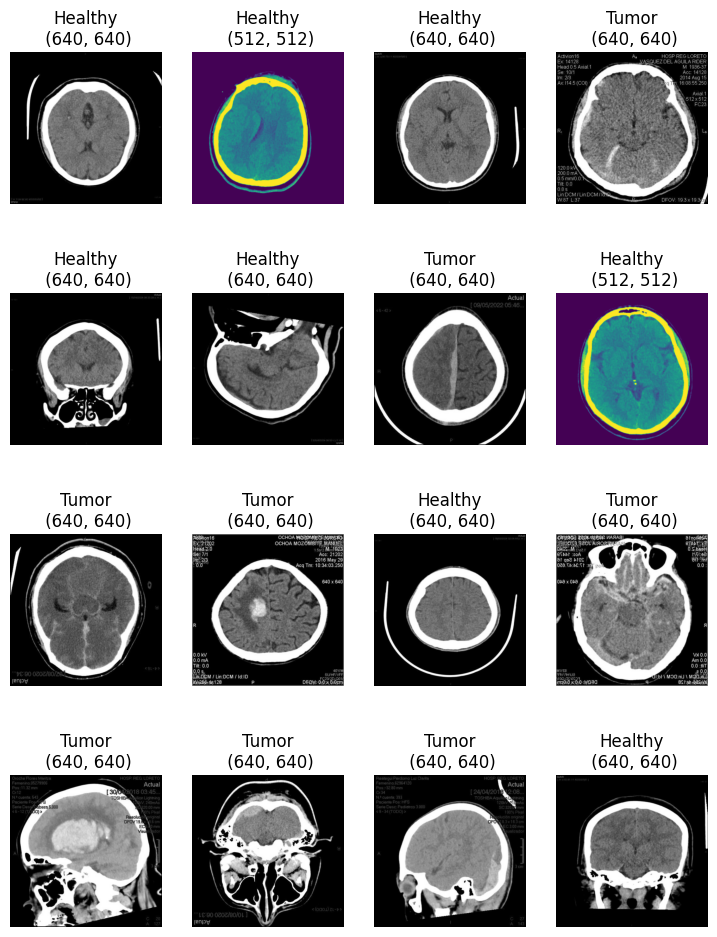

In [13]:
show_random_images(image_paths_CT, 4, 4)

### Visualize random MRI scan images

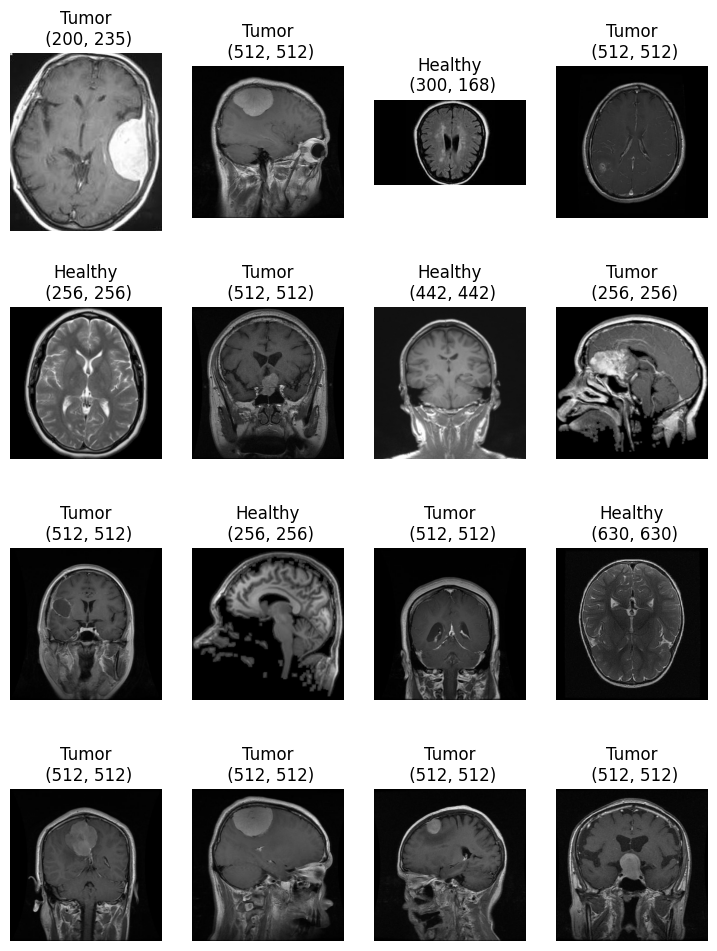

In [14]:
show_random_images(image_paths_MRI_balanced, 4, 4)

## Split CT and MRI scan images into Training and Testing sets

### Import necessary libraries

In [15]:
from sklearn.model_selection import train_test_split as tts
import shutil

### Split the CT images

In [16]:
train_CT, test_CT = tts(image_paths_CT, test_size=.25)

### Split the MRI images

In [17]:
train_MRI, test_MRI = tts(image_paths_MRI_balanced, test_size=.25)

In [18]:
len(train_MRI), len(test_MRI)

(3000, 1000)

### Make a new directory containing the splitted data

In [19]:
# Create train and test directorie
train_ct_path = path / "Dataset/CT Split/Train"
test_ct_path = path / "Dataset/CT Split/Test"
train_mri_path = path / "Dataset/MRI Split/Train"
test_mri_path = path / "Dataset/MRI Split/Test"

# Create directories if they don't exist
train_ct_path.mkdir(parents=True, exist_ok=True)
test_ct_path.mkdir(parents=True, exist_ok=True)
train_mri_path.mkdir(parents=True, exist_ok=True)
test_mri_path.mkdir(parents=True, exist_ok=True)

inspect_data(path)

1
└── Dataset
    ├── MRI Split
    │   ├── Test
    │   │   ├── Healthy (499 files)
    │   │   └── Tumor (501 files)
    │   └── Train
    │       ├── Healthy (1501 files)
    │       └── Tumor (1499 files)
    ├── CT Split
    │   ├── Test
    │   │   ├── Healthy (568 files)
    │   │   └── Tumor (587 files)
    │   └── Train
    │       ├── Healthy (1732 files)
    │       └── Tumor (1731 files)
    ├── Brain Tumor MRI images (1 files)
    │   ├── Healthy (2000 files)
    │   └── Tumor (3000 files)
    └── Brain Tumor CT scan Images (1 files)
        ├── Healthy (2300 files)
        └── Tumor (2318 files)


### Make a function to copy files to the new directory

In [20]:
def copy_files(files, destination, overwrite):
    if not overwrite and any(destination.iterdir()):
        print("Directory is not empty, please activate overwrite to replace current contents")
        return

    if overwrite and any(destination.iterdir()):
        shutil.rmtree(destination)
        destination.mkdir(parents=True, exist_ok=True)

    for file in files:
        dest = destination / file.parent.name / file.name
        dest.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy(str(file), str(dest))

    print("Files copied successfully.")

### Copy the files

In [21]:
REPLACE_FILES = False
# Copy CT files
copy_files(train_CT, train_ct_path, REPLACE_FILES)
copy_files(test_CT, test_ct_path, REPLACE_FILES)

# Copy MRI files
copy_files(train_MRI, train_mri_path, REPLACE_FILES)
copy_files(test_MRI, test_mri_path, REPLACE_FILES)

inspect_data(path)

Directory is not empty, please activate overwrite to replace current contents
Directory is not empty, please activate overwrite to replace current contents
Directory is not empty, please activate overwrite to replace current contents
Directory is not empty, please activate overwrite to replace current contents
1
└── Dataset
    ├── MRI Split
    │   ├── Test
    │   │   ├── Healthy (499 files)
    │   │   └── Tumor (501 files)
    │   └── Train
    │       ├── Healthy (1501 files)
    │       └── Tumor (1499 files)
    ├── CT Split
    │   ├── Test
    │   │   ├── Healthy (568 files)
    │   │   └── Tumor (587 files)
    │   └── Train
    │       ├── Healthy (1732 files)
    │       └── Tumor (1731 files)
    ├── Brain Tumor MRI images (1 files)
    │   ├── Healthy (2000 files)
    │   └── Tumor (3000 files)
    └── Brain Tumor CT scan Images (1 files)
        ├── Healthy (2300 files)
        └── Tumor (2318 files)


## Data Augmentation

### Import necessary libraries

In [22]:
from torchvision import transforms

### Implement a simple trivial augment

In [23]:
data_transform_trivial = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to 1-channel grayscale
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.ToTensor(),  # Converts PIL Image to tensor (now 1 channel)
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

## Create dataset object for CT and MRI images

### Import necessary libraries

In [24]:
from torchvision import datasets

### Create the datasets

In [25]:
train_CT_dataset = datasets.ImageFolder(
    root=train_ct_path,
    transform=data_transform_trivial
)

test_CT_dataset = datasets.ImageFolder(
    root=test_ct_path,
    transform=data_transform_trivial
)

train_MRI_dataset = datasets.ImageFolder(
    root=train_mri_path,
    transform=data_transform_trivial
)

test_MRI_dataset = datasets.ImageFolder(
    root=test_mri_path,
    transform=data_transform_trivial
)

## Create dataloader object for CT and MRI images

### Import necessary libraries

In [26]:
from torch.utils.data import DataLoader

In [27]:
train_CT_dataloader = DataLoader(
    dataset=train_CT_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True
)

test_CT_dataloader = DataLoader(
    dataset=test_CT_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=False
)

train_MRI_dataloader = DataLoader(
    dataset=train_MRI_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True
)

test_MRI_dataloader = DataLoader(
    dataset=test_MRI_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=False
)

# Model Creation (MRI images)

## Import necessary libraries

In [28]:
import torch
from torch import nn
from tqdm import tqdm
from torchvision import models

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Create a predefined ResNetmodel

In [30]:
tumor_classifier_resnet_0 = models.resnet50(weights=None)

tumor_classifier_resnet_0.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
tumor_classifier_resnet_0 = tumor_classifier_resnet_0.to(device)
tumor_classifier_resnet_0

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
def train_model(model, dataloader, criterion, optimizer, device, num_epochs=10):
    model = model.to(device)  # 🔑 Move model to the device (GPU/CPU) first!
    model.train()

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Data to device

            optimizer.zero_grad()
            outputs = model(inputs)  # Now model and data are on same device
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

def test_model(model, dataloader, criterion, device):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
      for inputs, labels in dataloader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  accuracy = 100 * correct / total
  print(f"Test Loss: {running_loss/len(dataloader)}, Accuracy: {accuracy}%")


In [40]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(tumor_classifier_resnet_0.parameters(), lr=0.0001)

In [65]:
train_model(tumor_classifier_resnet_0, train_MRI_dataloader, loss_fn, optimizer, device, num_epochs=4)

 25%|██▌       | 1/4 [00:46<02:20, 46.77s/it]

Epoch 1/4, Loss: 0.010389323428984078


 50%|█████     | 2/4 [01:33<01:34, 47.03s/it]

Epoch 2/4, Loss: 0.011123924054505125


 75%|███████▌  | 3/4 [02:21<00:47, 47.20s/it]

Epoch 3/4, Loss: 0.013488267192944013


100%|██████████| 4/4 [03:07<00:00, 46.99s/it]

Epoch 4/4, Loss: 0.009263625539847936


In [66]:
test_model(tumor_classifier_resnet_0, test_MRI_dataloader, loss_fn, device)

Test Loss: 0.03199281606976001, Accuracy: 98.8%


In [67]:
from safetensors.torch import save_file

save_file(tumor_classifier_resnet_0.state_dict(), "tumor_classifier_resnet_2v9.safetensors")